In [1]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
import numpy as np
from transformers import BertTokenizer, BertModel
import torch


In [2]:
# Load dataset
df = pd.read_csv("cleaned_call_logs.csv")

In [3]:
# Preprocessing function
def clean_text(text):
    text = re.sub(r"caller:|receiver:", "", text, flags=re.IGNORECASE)  # Remove labels
    text = text.lower()  # Convert to lowercase
    text = re.sub(r"\d+", "", text)  # Remove numbers
    text = re.sub(r"[^\w\s]", "", text)  # Remove punctuation
    stop_words = set(stopwords.words("english"))
    text = " ".join([word for word in text.split() if word not in stop_words])  # Remove stopwords
    return text

df["cleaned_dialogue"] = df["dialogue"].apply(clean_text)

In [8]:
# 1. CountVectorizer
count_vectorizer = CountVectorizer(max_features=5000)
X_count = count_vectorizer.fit_transform(df["cleaned_dialogue"])

# 2. TF-IDF (current approach)
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf_vectorizer.fit_transform(df["cleaned_dialogue"])

# 3. Word2Vec
# Prepare sentences for Word2Vec
sentences = [text.split() for text in df["cleaned_dialogue"]]
w2v_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1)

# Create document vectors by averaging word vectors
X_w2v = np.zeros((len(sentences), 100))
for idx, sentence in enumerate(sentences):
    vectors = [w2v_model.wv[word] for word in sentence if word in w2v_model.wv]
    if vectors:
        X_w2v[idx] = np.mean(vectors, axis=0)

In [10]:
# Split data for each feature extraction method
X_train_count, X_test_count, y_train_count, y_test_count = train_test_split(X_count, df["labels"], test_size=0.2, random_state=42)
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(X_tfidf, df["labels"], test_size=0.2, random_state=42)
X_train_w2v, X_test_w2v, y_train_w2v, y_test_w2v = train_test_split(X_w2v, df["labels"], test_size=0.2, random_state=42)

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

            Method  Accuracy  Precision    Recall  F1-Score
0  CountVectorizer  1.000000   1.000000  1.000000  1.000000
1           TF-IDF  0.992063   0.987342  1.000000  0.993631
2         Word2Vec  0.972222   0.986928  0.967949  0.977346


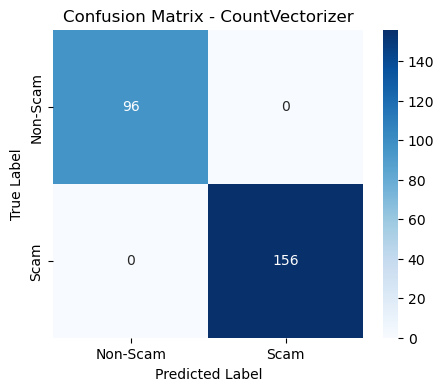

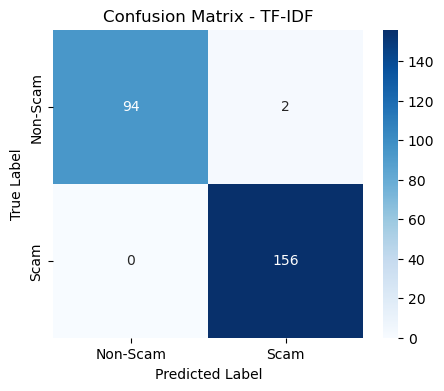

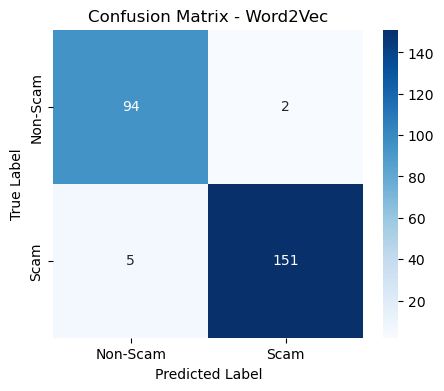

In [67]:
# Train Logistic Regression model
model_count = LogisticRegression(max_iter=1000)
model_count.fit(X_train_count, y_train_count)
model_tfidf = LogisticRegression(max_iter=1000)
model_tfidf.fit(X_train_tfidf, y_train_tfidf)
model_w2v = LogisticRegression(max_iter=1000)
model_w2v.fit(X_train_w2v, y_train_w2v)

# Evaluate models
y_pred_count = model_count.predict(X_test_count)
y_pred_tfidf = model_tfidf.predict(X_test_tfidf)
y_pred_w2v = model_w2v.predict(X_test_w2v)

# Function to evaluate models and return performance metrics
def evaluate_model(model_name, y_test, y_pred):
    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    return [model_name, acc, precision, recall, f1]

# Evaluate each model and store results
results = []
results.append(evaluate_model("CountVectorizer", y_test_count, y_pred_count))
results.append(evaluate_model("TF-IDF", y_test_tfidf, y_pred_tfidf))
results.append(evaluate_model("Word2Vec", y_test_w2v, y_pred_w2v))

# Create a DataFrame for a clean table output
df_results = pd.DataFrame(results, columns=["Method", "Accuracy", "Precision", "Recall", "F1-Score"])

# Display the results as a Pandas DataFrame table
print(df_results)

# Plot confusion matrices
def plot_confusion_matrix(model_name, y_test, y_pred):
    plt.figure(figsize=(5,4))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Scam", "Scam"], yticklabels=["Non-Scam", "Scam"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()

# Plot confusion matrix for each model
plot_confusion_matrix("CountVectorizer", y_test_count, y_pred_count)
plot_confusion_matrix("TF-IDF", y_test_tfidf, y_pred_tfidf)
plot_confusion_matrix("Word2Vec", y_test_w2v, y_pred_w2v)


In [76]:
# Use the count vectorizer model to predict the label and probability of a new dialogue
new_dialogue = """
Are you looking to adopt a pet? We have a wide variety of animals available for adoption.
Why not visit our shelter today and find your perfect match?
We are open from 10 am to 5 pm, Monday to Friday, and 10 am to 4 pm on Saturdays.
We look forward to seeing you soon!
"""
new_dialogue = clean_text(new_dialogue)  # Apply your text preprocessing

# Convert text into a sparse matrix using CountVectorizer
X_new = count_vectorizer.transform([new_dialogue])

# Get the predicted label
y_new = model_count.predict(X_new)

# Get probability estimates
prob_new = model_count.predict_proba(X_new)

# Ensure correct interpretation of prediction
label_index = np.argmax(prob_new)  # Find index of max probability
label = "Scam" if label_index == 1 else "Not Scam"

print("Predicted label:", label)
print("Predicted label probability:", prob_new[0][label_index])

Predicted label: Scam
Predicted label probability: 0.9184062993195541


In [77]:
# Use the TFIDF Logistic Regression model to predict the label and the probability of the label for the following dialogue
dialogue = """
Are you looking to adopt a pet? We have a wide variety of animals available for adoption.
Why not visit our shelter today and find your perfect match?
We are open from 10 am to 5 pm, Monday to Friday, and 10 am to 4 pm on Saturdays.
We look forward to seeing you soon!
"""
cleaned_dialogue = clean_text(dialogue)
X = tfidf_vectorizer.transform([cleaned_dialogue])
y_pred = model_tfidf.predict(X)
y_pred_proba = model_tfidf.predict_proba(X)
label_index = np.argmax(y_pred_proba)  # Get index of highest probability
label = "Scam" if label_index == 1 else "Not Scam"
print("Predicted label:", label)
print("Predicted label probability:", y_pred_proba[0][label_index])


Predicted label: Not Scam
Predicted label probability: 0.7337346700458203


In [75]:
# Use the Word2Vec Logistic Regression model to predict the label and the probability of the label for the following dialogue
dialogue = """
Are you looking to adopt a pet? We have a wide variety of animals available for adoption.
Why not visit our shelter today and find your perfect match?
We are open from 10 am to 5 pm, Monday to Friday, and 10 am to 4 pm on Saturdays.
We look forward to seeing you soon!
"""

cleaned_dialogue = clean_text(dialogue)
sentence = cleaned_dialogue.split()
vectors = [w2v_model.wv[word] for word in sentence if word in w2v_model.wv]
if vectors:
    X = np.mean(vectors, axis=0)
    X = X.reshape(1, -1)
    y_pred = model_w2v.predict(X)
    y_pred_proba = model_w2v.predict_proba(X)
    label_index = np.argmax(y_pred_proba)  # Get index of highest probability
    label = "Scam" if label_index == 1 else "Not Scam"
    print("Predicted label:", label)
    print("Predicted label probability:", y_pred_proba[0][label_index])
else:
    print("No word vectors found for the dialogue")


Predicted label: Not Scam
Predicted label probability: 0.9997674883759792
